In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import requests
import json
import datetime

## Read and format PJM LMPs

In [2]:
pjmdf = pd.read_csv('rawdf_pjm.csv')
pjmdf.drop(labels = 'Unnamed: 0', axis = 1, inplace = True)
pjmdf.head()

,pnodeId,price_01,price_02,price_03,price_04,price_05,price_06,price_07,price_08,price_09,price_10,price_11,price_12,price_13,price_14,price_15,price_16,price_17,price_18,price_19,price_20,price_21,price_22,price_23,price_24,publishDate
0,32417601,2.48,14.23,13.66,21.55,21.44,21.79,22.94,24.15,23.06,26.53,29.16,26.03,27.36,26.25,26.41,26.57,28.61,65.92,72.45,75.68,76.83,46.26,44.68,28.91,2008-01-01
1,32417601,26.73,31.48,30.66,27.92,35.38,31.03,41.06,90.86,108.73,138.98,102.04,89.39,80.84,92.72,52.36,28.21,52.29,85.35,129.36,153.18,161.66,102.92,98.31,65.93,2008-01-02
2,32417601,191.99,60.30,45.30,70.30,61.71,49.43,56.30,113.23,105.20,78.29,45.28,52.23,69.05,66.20,53.44,31.91,55.90,31.72,73.64,68.42,76.62,70.43,57.13,63.90,2008-01-03
3,32417601,40.36,35.20,33.61,27.98,24.98,30.54,41.90,66.48,78.02,65.31,68.80,38.89,47.09,33.41,24.32,26.75,28.74,60.48,44.26,38.80,38.36,29.07,30.21,26.46,2008-01-04
4,32417601,35.13,34.19,25.23,24.42,23.09,24.00,23.54,30.27,37.55,56.69,67.66,56.65,33.43,38.33,29.52,33.23,39.43,69.88,45.50,42.07,35.96,35.54,24.52,27.46,2008-01-05


In [3]:
# rearrange lmp dataframe to be indexed by date/hour, with 1 col per node
idx = pd.date_range('1/1/2008', '12/31/2012 23:00:00', freq = 'H')
lmpdf = pd.DataFrame(index = idx)

for node in pjmdf['pnodeId'].unique():
    nodedf = pjmdf[pjmdf['pnodeId']==node]
    #df = dfpn7601[:1460]
    nodedf = nodedf.drop('pnodeId',1)
    nodedf = nodedf.drop('publishDate',1)
    nodedf = nodedf.fillna(0)
    nodedf = nodedf.stack()
    col_name = 'lmp_' + str(node)[-3:]
    nodedf.index = idx
    lmpdf[col_name] = nodedf


In [4]:
lmpdf.head()

,lmp_601,lmp_635,lmp_525,lmp_547,lmp_629,lmp_633,lmp_599,lmp_527,lmp_545,lmp_631,lmp_673
2008-01-01 00:00:00,2.48,2.79,2.46,2.85,3.08,2.79,2.48,2.45,2.78,3.12,33.52
2008-01-01 01:00:00,14.23,13.92,14.13,14.47,13.89,13.92,14.22,14.11,14.54,13.94,35.25
2008-01-01 02:00:00,13.66,13.34,13.58,13.85,13.34,13.34,13.66,13.57,13.89,13.38,26.40
2008-01-01 03:00:00,21.55,21.18,21.47,21.77,21.21,21.17,21.54,21.45,21.80,21.26,26.90
2008-01-01 04:00:00,21.44,21.02,21.36,21.67,21.07,21.02,21.44,21.34,21.71,21.11,28.55


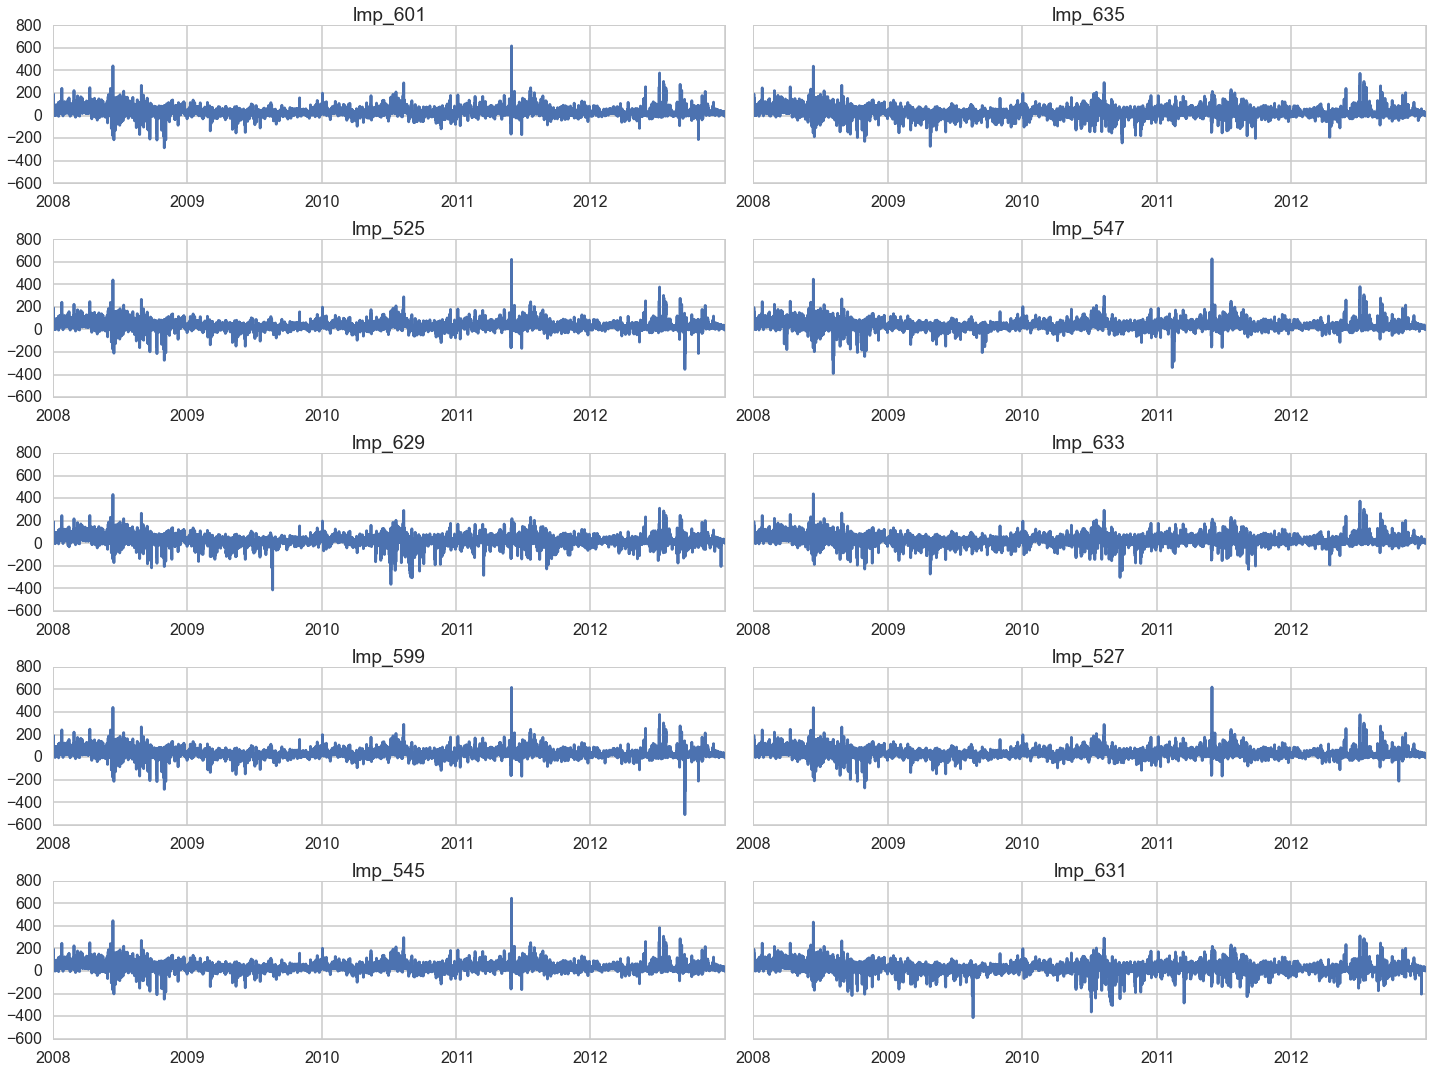

In [51]:
fig, axes = plt.subplots(nrows=5,ncols=2,figsize=(20,15),tight_layout=True,sharey=True)
headers = list(lmpdf)
ax = axes.ravel()

for i in range(10):
    k = lmpdf.iloc[:,i]
    k.plot(ax=ax[i], title=headers[i])
    
    
# ax1.plot(lmpdf['lmp_601'])
# ax1.set_title('lmp_601')
# ax2.plot(lmpdf['lmp_635'])
# ax2.set_title('lmp_635')
# ax3.plot(lmpdf['lmp_525'])
# ax3.set_title('lmp_525')
# ax4.plot(lmpdf['lmp_547'])
# ax5.plot(lmpdf['lmp_629'])
# ax6.plot(lmpdf['lmp_633'])
# ax7.plot(lmpdf['lmp_599'])
# ax8.plot(lmpdf['lmp_527'])
# ax9.plot(lmpdf['lmp_545'])
# ax10.plot(lmpdf['lmp_631'])

## Read in and format PJM load data

In [17]:
pjm_load = pd.read_csv('data/PJM_hourly_load_08_15.csv')
ldf = pjm_load[:1827] #5 yrs: 2008-2012
ldf = ldf.drop('DATE',1)
ldf = ldf.drop('COMP',1)
ldf = ldf.drop('Unnamed: 26',1)
ldf = ldf.drop('Unnamed: 27',1)
ldf = ldf.fillna(0)
ldf = ldf.stack()
idx = pd.date_range('1/1/2008', '12/31/2012 23:00:00', freq = 'H')
ldf.index = idx

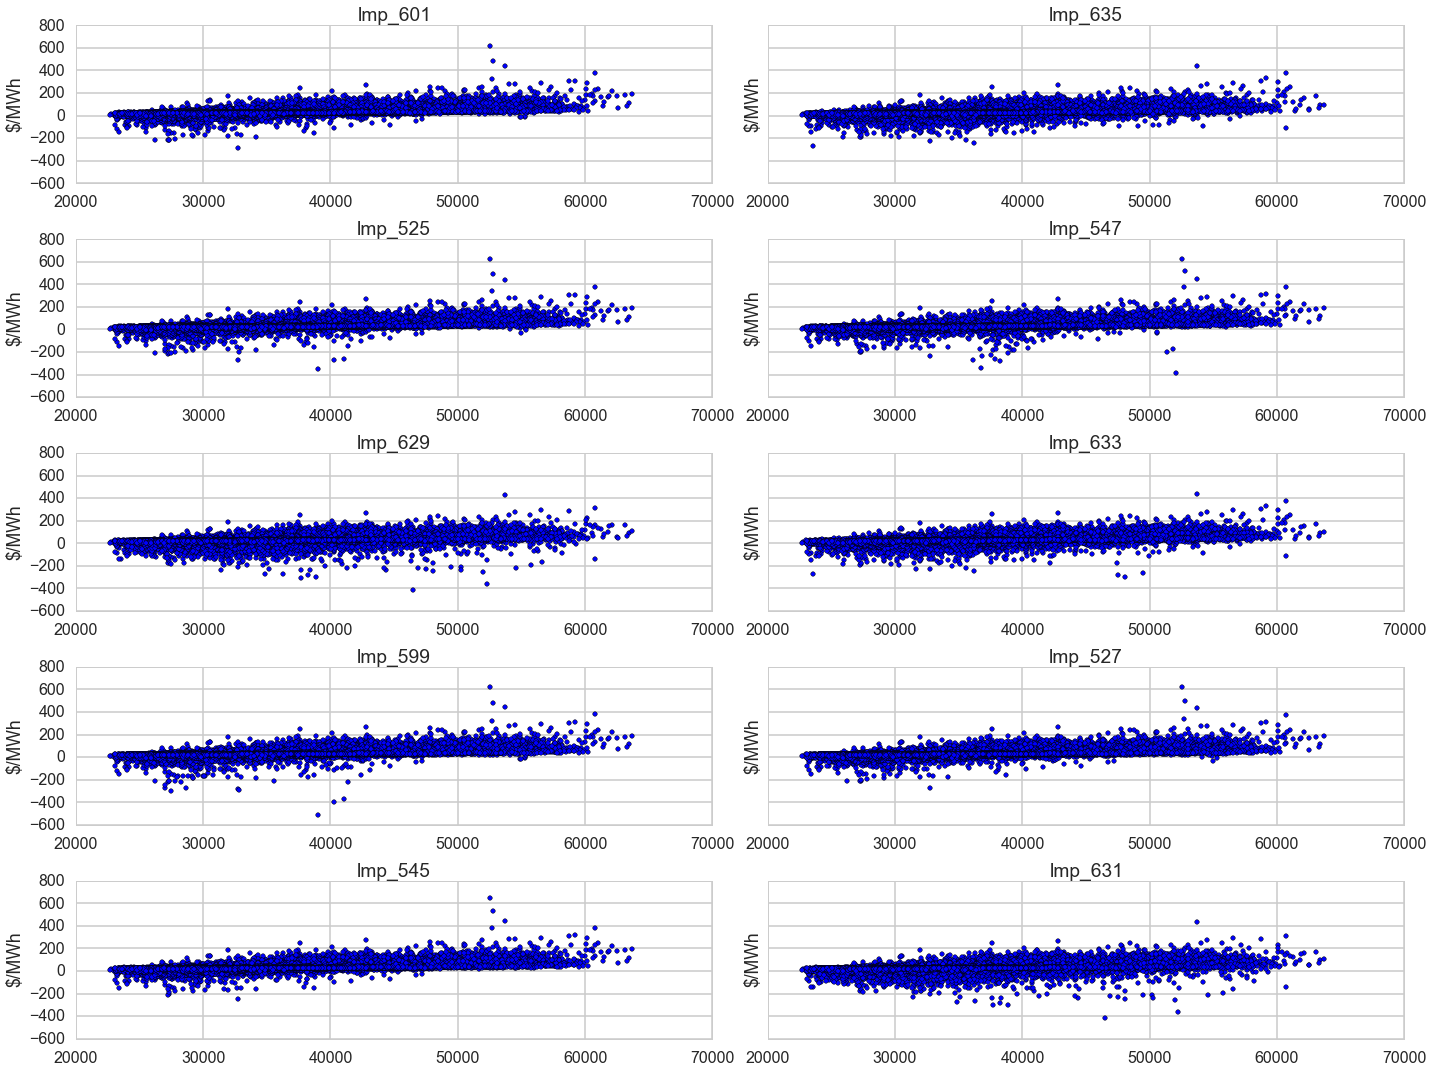

In [54]:
fig, axes = plt.subplots(nrows=5,ncols=2,figsize=(20,15),tight_layout=True,sharey=True)
headers = list(lmpdf)
ax = axes.ravel()

for i in range(10):
    x = ldf
    y = lmpdf.iloc[:,i]
    ax[i].scatter(x,y)
    ax[i].set_title(headers[i])
    ax[i].set_xlim([20000,70000])
    ax[i].set_ylabel("$/MWh")


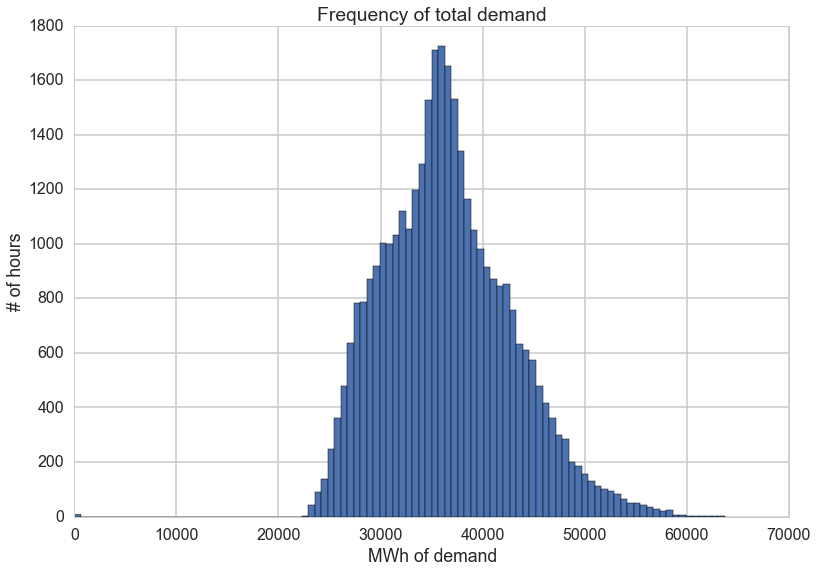

In [10]:
ldf = pd.DataFrame(load)
ldf.hist(bins=100)
plt.title('Frequency of total demand')
plt.xlabel('MWh of demand')
plt.ylabel('# of hours')

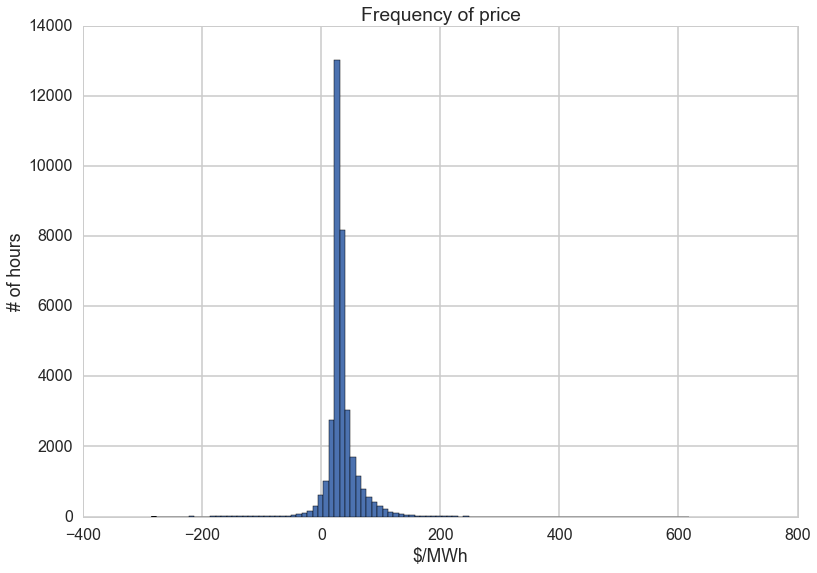

In [11]:
lmpdf = pd.DataFrame(lmp)
lmpdf.hist(bins=100)
plt.title('Frequency of price')
plt.xlabel('$/MWh')
plt.ylabel('# of hours')

In [12]:
pjm_wind = pd.read_csv('data/PJM_Wind/PJM_hourly_wind_08_11.csv')
wdf = pjm_wind[:1460]
wdf = wdf.drop('DATE',1)
wdf = wdf.drop('COMP',1)
wdf = wdf.fillna(0)
wind = wdf.stack()
rng = pd.date_range('1/1/2008', periods = 35040, freq = 'H')
wind.index = rng

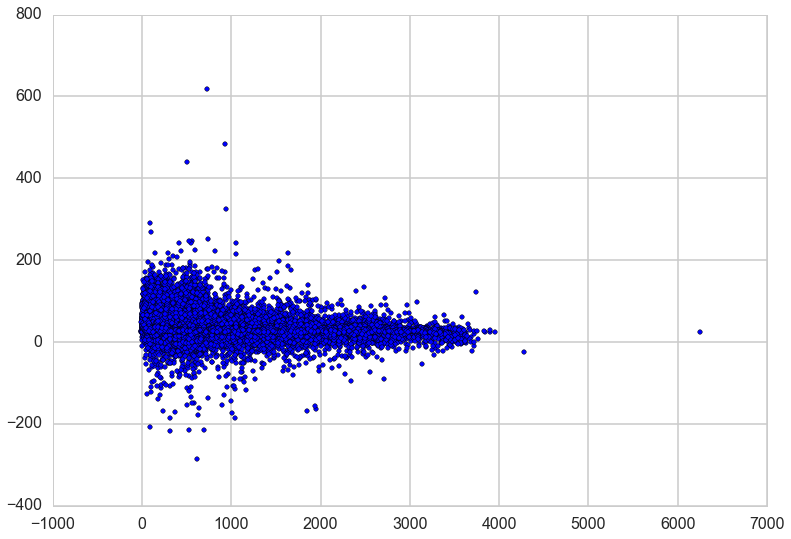

In [13]:
plt.scatter(wind, lmp)

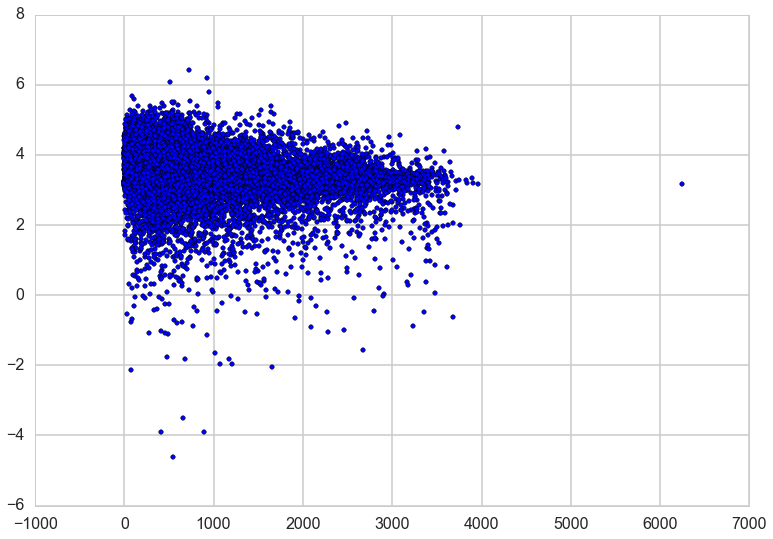

In [14]:
plt.scatter(wind, np.log(lmp))

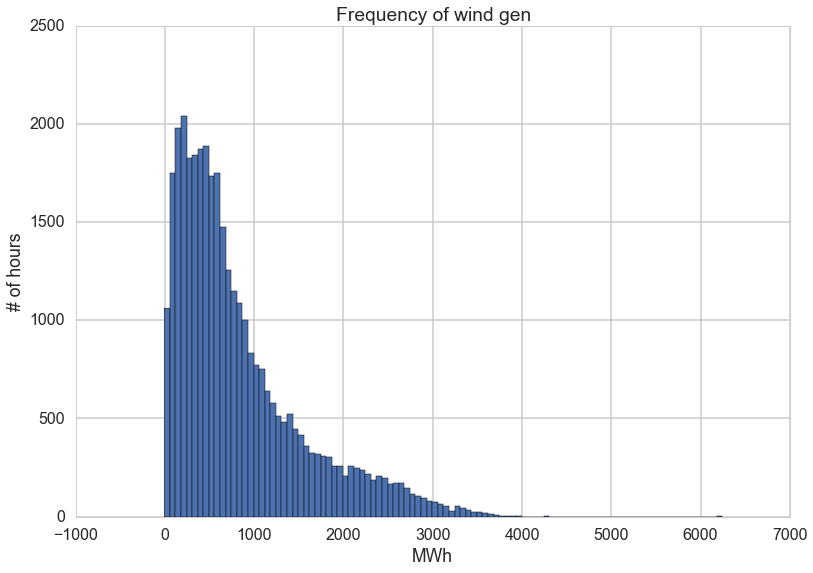

In [15]:
winddf = pd.DataFrame(wind)
winddf.hist(bins=100)
plt.title('Frequency of wind gen')
plt.xlabel('MWh')
plt.ylabel('# of hours')

In [16]:
temp = np.log(pd.DataFrame(wind))

temp.head()

,0
2008-01-01 00:00:00,6.546932
2008-01-01 01:00:00,6.520689
2008-01-01 02:00:00,6.449849
2008-01-01 03:00:00,6.417304
2008-01-01 04:00:00,6.430498


In [17]:
lmpdf = pd.DataFrame(lmp)
loaddf = pd.DataFrame(load)
winddf = pd.DataFrame(wind)

#lmpdf.columns = ['date','lmp']

In [18]:
lmpdf['wind'] = winddf
lmpdf['load'] = loaddf
lmpdf.columns = ['lmp','wind', 'load']

In [19]:
lmpdf.to_csv('../df.csv')
dfNG.to_csv('../ngdf.csv')

NameError: name 'dfNG' is not defined

In [20]:
import statsmodels.formula.api as smf

In [21]:
lm = smf.ols(formula = 'lmp ~ load + wind', data = lmpdf).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lmp   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     9322.
Date:                Sat, 28 Nov 2015   Prob (F-statistic):               0.00
Time:                        11:16:05   Log-Likelihood:            -1.5502e+05
No. Observations:               35040   AIC:                         3.101e+05
Df Residuals:                   35037   BIC:                         3.101e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -42.7996      0.670    -63.867      0.000       -44.113   -41.486
load           0.0022   1.73e-05    128.243      0.000         0.002     0.002
wind          -0.0046      0.000    -30.583      0.000        -0.005    -0.004
==============================================================================
Omnibus:                    17431.407   Durbin-Watson:                   0.782
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2328542.211
Skew:                           1.384   Prob(JB):                         0.00
Kurtosis:                      42.840   Cond. No.                     2.31e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Adding in NG prices

In [119]:
df = pd.read_csv('data/LMP_features_08_12.csv')
df = df.set_index(['date'])

In [33]:
lm = smf.ols(formula = 'lmp ~ load + ng + wind', data = df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lmp   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     7578.
Date:                Sat, 28 Nov 2015   Prob (F-statistic):               0.00
Time:                        11:41:00   Log-Likelihood:            -1.5374e+05
No. Observations:               35040   AIC:                         3.075e+05
Df Residuals:                   35036   BIC:                         3.075e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -53.7179      0.680    -79.038      0.000       -55.050   -52.386
load           0.0021   1.68e-05    125.885      0.000         0.002     0.002
ng             2.3933      0.046     51.680      0.000         2.303     2.484
wind          -0.0021      0.000    -13.847      0.000        -0.002    -0.002
==============================================================================
Omnibus:                    15399.868   Durbin-Watson:                   0.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3221489.813
Skew:                           0.977   Prob(JB):                         0.00
Kurtosis:                      49.933   Cond. No.                     2.43e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
dflog = df
dflog['log_lmp'] = np.log(df['lmp'])
dflog['log_wind'] = np.log(df['wind'])
dflog['log_load'] = np.log(df['load'])
dflog['log_ng'] = np.log(df['ng'])

In [44]:
dflog = dflog.fillna(0)

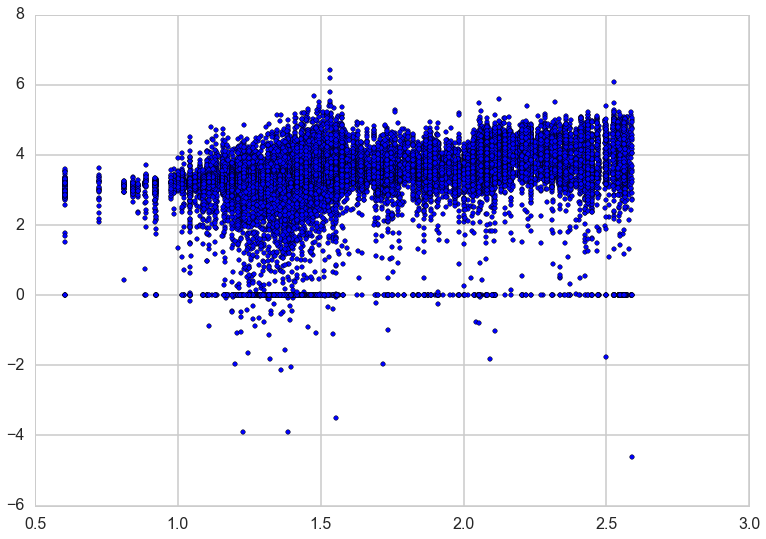

In [45]:
y = dflog['log_lmp']
x = dflog['log_ng']
#y = dflog['lmp']
#x = dflog['ng']

plt.scatter(x,y)

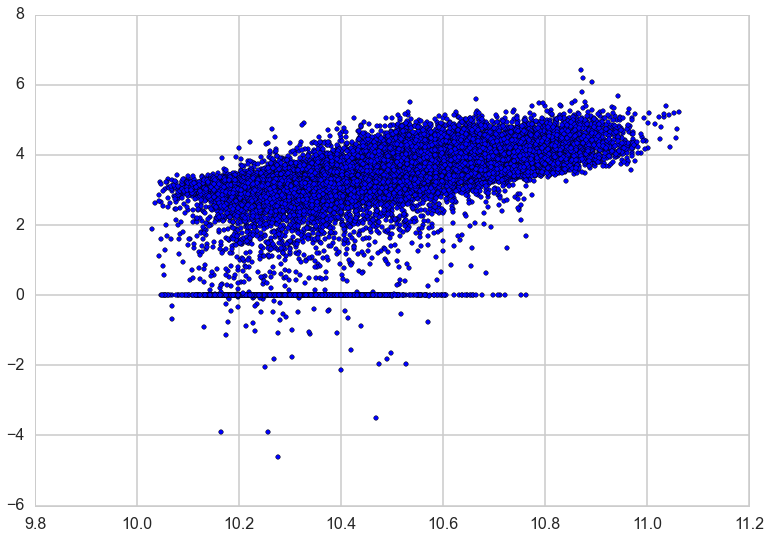

In [46]:
y = dflog['log_lmp']
x = dflog['log_load']

plt.scatter(x,y)

In [47]:
lm = smf.ols(formula = 'log_lmp ~ log_ng + log_load', data = dflog).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_lmp   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 28 Nov 2015   Prob (F-statistic):                nan
Time:                        11:54:27   Log-Likelihood:                    nan
No. Observations:               35040   AIC:                               nan
Df Residuals:                   35040   BIC:                               nan
Df Model:                          -1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept         nan        nan        nan        nan           nan       nan
log_ng            nan        nan        nan        nan           nan       nan
log_load          nan        nan        nan        nan           nan       nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                          nan
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
lm.pvalues

Intercept   NaN
log_ng      NaN
log_load    NaN
dtype: float64

In [120]:
df['month'] = pd.to_datetime(df.index).month

In [79]:
#df = df.drop('log_wind',1)
df = df.drop('log_lmp',1)
df = df.drop('log_load',1)
df = df.drop('log_ng',1)

In [90]:
df.set_index(['month',df.index])
#df.head()
df.head()

,lmp,wind,load,ng,month
date,,,,,
1/1/2008 0:00,2.48,697.102,33534,7.83,1
1/1/2008 1:00,14.23,679.046,32632,7.83,1
1/1/2008 2:00,13.66,632.607,31828,7.83,1
1/1/2008 3:00,21.55,612.350,31565,7.83,1
1/1/2008 4:00,21.44,620.483,31542,7.83,1


In [121]:
#from pandas.stats.plm import PanelOLS
#model = PanelOLS(y=df['lmp'], x=df['ng'], time_effects=True)
#df.ix[1]
model = smf.MixedLM.from_formula("lmp ~ ng", df, groups=df["month"])
result = model.fit()

In [122]:
print result.summary()

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: lmp         
No. Observations: 35040   Method:             REML        
No. Groups:       12      Scale:              543.5482    
Min. group size:  2712    Likelihood:         -160088.6417
Max. group size:  2976    Converged:          Yes         
Mean group size:  2920.0                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       17.289    1.125 15.366 0.000 15.084 19.494
ng               3.281    0.054 60.568 0.000  3.175  3.387
Intercept RE    14.018    0.271                           



In [123]:
df.set_index(['month',df.index],inplace=True)
p = df.to_panel()

In [135]:
#model = PanelOLS(y=p['lmp'], x=p['ng'], time_effects=True)
m=pd.ols(y=p['lmp'],x={'ng':p['ng'],'ld':p['load'],'wd':p['wind']},time_effects=True)


In [136]:
m


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <ld> + <ng> + <wd>

Number of Observations:         35040
Number of Degrees of Freedom:   15

R-squared:         0.4093
Adj R-squared:     0.4091

Rmse:             18.8317

F-stat (3, 35025):  1733.6337, p-value:     0.0000

Degrees of Freedom: model 14, resid 35025

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
            ld     0.0025     0.0000     135.16     0.0000     0.0025     0.0026
            ng     2.2908     0.0465      49.29     0.0000     2.1997     2.3819
            wd    -0.0025     0.0002     -15.41     0.0000    -0.0028    -0.0022
---------------------------------End of Summary---------------------------------

In [133]:
df.head()

lmp     wind   load    ng
month date                                      
1     1/1/2008 0:00   2.48  697.102  33534  7.83
      1/1/2008 1:00  14.23  679.046  32632  7.83
      1/1/2008 2:00  13.66  632.607  31828  7.83
      1/1/2008 3:00  21.55  612.350  31565  7.83
      1/1/2008 4:00  21.44  620.483  31542  7.83

In [138]:
lm = smf.ols(formula = 'lmp ~ ng + load + wind', data = df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lmp   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     7578.
Date:                Sun, 29 Nov 2015   Prob (F-statistic):               0.00
Time:                        11:00:01   Log-Likelihood:            -1.5374e+05
No. Observations:               35040   AIC:                         3.075e+05
Df Residuals:                   35036   BIC:                         3.075e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -53.7179      0.680    -79.038      0.000       -55.050   -52.386
ng             2.3933      0.046     51.680      0.000         2.303     2.484
load           0.0021   1.68e-05    125.885      0.000         0.002     0.002
wind          -0.0021      0.000    -13.847      0.000        -0.002    -0.002
==============================================================================
Omnibus:                    15399.868   Durbin-Watson:                   0.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3221489.813
Skew:                           0.977   Prob(JB):                         0.00
Kurtosis:                      49.933   Cond. No.                     2.43e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""